### download dataset from

https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html

download cells_images from malaria dataset

# Imports

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd
import glob

import os
import cv2
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter
from concurrent import futures
import threading
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout,Input
from keras.models import Sequential
from keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Total dataset

In [4]:
base_dir = os.path.join('C:/Users/Hassan/JUPYTER/Detecting malaria/cell_images/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)


(13779, 13779)

Arranging and labeling data 

In [5]:
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,C:/Users/Hassan/JUPYTER/Detecting malaria/cell...,malaria
1,C:/Users/Hassan/JUPYTER/Detecting malaria/cell...,malaria
2,C:/Users/Hassan/JUPYTER/Detecting malaria/cell...,healthy
3,C:/Users/Hassan/JUPYTER/Detecting malaria/cell...,healthy
4,C:/Users/Hassan/JUPYTER/Detecting malaria/cell...,healthy


Spliting data into train, test and validation sets

In [6]:
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values,
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)

(17361,) (1929,) (8268,)


Counting labels of each set

In [7]:
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))


Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


In [8]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS,
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [9]:
ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]


In [10]:
print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape 

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_14: working on img num: 5000
ThreadPoolExecutor-0_19: working on img num: 10000
ThreadPoolExecutor-0_7: working on img num: 15000
ThreadPoolExecutor-0_1: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-0_18: working on img num: 0
ThreadPoolExecutor-0_0: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-0_14: working on img num: 0
ThreadPoolExecutor-0_4: working on img num: 5000
ThreadPoolExecutor-0_6: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

Viewing images

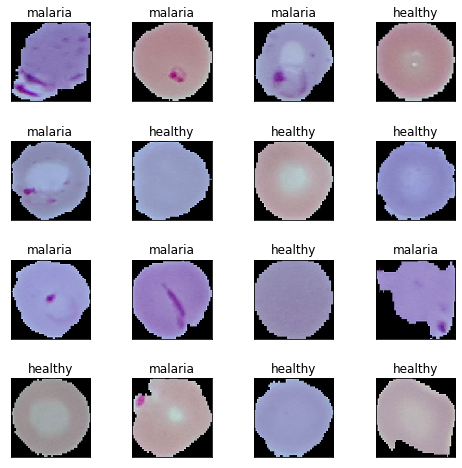

In [11]:
plt.figure(1 , figsize = (8 , 8))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

Encoding labels as binary

In [12]:
le =LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [13]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

Convolutional Neural Network

In [14]:
inp =Input(shape=INPUT_SHAPE)

conv1 = Conv2D(32, kernel_size=(3, 3),
                               activation='relu', padding='same')(inp)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3),
                               activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),
                               activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

flat = Flatten()(pool3)

hidden1 = Dense(512, activation='relu')(flat)
drop1 = Dropout(rate=0.3)(hidden1)
hidden2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.3)(hidden2)

out = Dense(1, activation='sigmoid')(drop2)

model =Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 125, 125, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 128)       73856     
______________________________

Training the model

In [15]:
#callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_imgs_scaled, val_labels_enc),
                    verbose=1)


Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 682s 39ms/step - loss: 0.4109 - accuracy: 0.8065 - val_loss: 0.1827 - val_accuracy: 0.9378
Epoch 2/25
17361/17361 [==============================] - 692s 40ms/step - loss: 0.1671 - accuracy: 0.9467 - val_loss: 0.1371 - val_accuracy: 0.9580
Epoch 3/25
17361/17361 [==============================] - 709s 41ms/step - loss: 0.1383 - accuracy: 0.9548 - val_loss: 0.1354 - val_accuracy: 0.9539
Epoch 4/25
17361/17361 [==============================] - 721s 42ms/step - loss: 0.1194 - accuracy: 0.9608 - val_loss: 0.1312 - val_accuracy: 0.9611
Epoch 5/25
17361/17361 [==============================] - 714s 41ms/step - loss: 0.0992 - accuracy: 0.9656 - val_loss: 0.1259 - val_accuracy: 0.9596
Epoch 6/25
17361/17361 [==============================] - 711s 41ms/step - loss: 0.0777 - accuracy: 0.9730 - val_loss: 0.1439 - val_accuracy: 0.9565
Epoch 7/25
17361/17361 [==============================] 